# 07 预训练语言模型

本 Notebook 中，我们将介绍预训练语言模型的概念，并展示其在文本情感分类任务中的应用。

## 7.1 前情回顾

在 `05Implement.ipynb` 中，我们实现了几种简单的模型；

在 `06Pre-trained Word Embeddings.ipynb` 中，我们使用了预训练词向量技术，有效提升了模型的性能。

然后，尽管使用了预训练词向量，模型的总参数量仍然较小，能存储的知识量也有限。

从模型训练后的测试结果来看，几乎所有模型的预测准确率都在 75% 以下（仅有使用了预训练词向量的 LSTM 模型达到了约 76%的准确率）。

## 7.2 预训练语言模型简介

近些年来，以 GPU 和 TPU 为代表的硬件计算能力大幅提升，促使了大规模深度学习模型的训练成为可能。

在 2018 年，以 OpenAI 提出的 GPT 以及 Google 公司提出了 BERT为代表的预训练语言模型受到了研究人员的广泛关注。

这些模型基于深层 Transformer 结构，利用了大规模的无标注数据进行训练，学习到了更加复杂的语义信息，在众多自然语言处理任务重获得了显著的性能提升。同时，模型能够便捷地适配于不同类型的下游任务，取代了繁琐的任务和特定的模型设计，开启了“预训练 + 精调”的自然语言处理新范式。

预训练语言模型大致可以分为以下三种类型：

1. Decoder-only 模型：这类模型主要关注如何基于给定的历史信息生成或预测输出，是语言模型中最为经典的建模方法。典型代表有 GPT 系列模型。

2. Encoder-only 模型：这类模型主要用于理解输入的上下文信息，通常用于文本分类、信息抽取、序列标注等任务。典型代表有 BERT、RoBERTa 等。

3. Encoder-Decoder 模型：这类模型结合了编码器和解码器的优点，能够同时处理输入和输出，适用于机器翻译等任务。典型代表有 T5、BART 等。

本项目是基于文本的情感分类任务，因此我们将使用 Encoder-only 模型中 BERT 系列的改进版本 MacBERT 进行实验。

## 7.3 BERT

BERT（Bidirectional Encoder Representations from Transformers）是由 Google 于 2018 年提出的一种预训练语言模型。

BERT 不仅充分利用了大规模无标注文本来挖掘其中丰富的语义信息，还提出了针对无标注文本设计的两种预训练任务，这些任务能够更加有效地学习文本的上下文语义信息。

具体来说，BERT 包含以下两个预训练任务：掩码语言模型（Masked Language Model, MLM）和下一个句子预测（Next Sentence Prediction, NSP）。

接下来，我们简要介绍一下这两个预训练任务，并说明它们为什么能够帮助模型学习更好的文本表示。关于 BERT 的更多细节，读者可以参考相关文献资料自行学习。

### 7.3.1 掩码语言模型

掩码语言模型（MLM）是一种用于训练 BERT 的预训练任务。其核心思想是通过随机掩盖输入文本中的一部分词语，并利用深层 Transformer 模型还原为原单词，迫使模型使用被掩码词周围的上下文信息还原掩码位置的词。

BERT 采用了 $15\%$ 的掩码比例，即输入序列中 $15\%$ 的词元被掩码。

当掩码时，模型使用 `[MASK]` 词元替换原词元，以表示该位置已被掩码。

然而，这样会造成预训练阶段和下游任务精调阶段之间的不一致，因为人为引入的 `[MASK]` 词元在下游任务中并不存在。

为缓解这个问题，当输入序列掩码时，BERT 采用了以下三种策略：

- $80\%$ 的概率使用 `[MASK]` 词元替换原词元。
- $10\%$ 的概率使用随机词元替换原词元。
- $10\%$ 的概率保持原词元不变。

下表给出了三种掩码方式的示例。

|输入序列|训练样本|
|-|-|
|原文本|他 去 商店 买了 些 牛奶 。|
|$80\%$ 概率替换为 `[MASK]`|他 去 `[MASK]` 买了 些 牛奶 。|
|$10\%$ 概率替换为随机词元|他 去 苹果 买了 些 牛奶 。|
|$10\%$ 概率保持原词元不变|他 去 商店 买了 些 牛奶 。|

通过掩码语言模型，BERT 能够强制学习到双向上下文，即预测一个位置时，需要同时利用左右两侧的上下文信息，从而使词表示的语义更加完整和丰富。

此外，掩码语言模型还可以促使模型学习词的多义性和语境依赖，并隐式学习语法结构信息。

### 7.3.2 下一个句子预测

在掩码语言模型预训练任务重，模型已经能够根据上下文还原掩码部分的词，从而学习上下文敏感的文本表示。

然而，对于阅读理解、文本蕴含等需要两端输入文本的任务来说，仅依靠掩码语言模型无法显式地学习两端输入文本的关联。

因此，BERT 引入了下一个句子预测（NSP）任务，以帮助模型学习句子级别的关系。

NSP 任务时一个二分类任务，需要判断句子 B 是不是句子 A 的下一个句子，其训练样本由以下方式产生：
- 正样本：来自自然文本中相邻的两个句子“句子 A”和“句子 B”，即构成“下一个句子”表示
- 负样本：将“句子 B”替换为语料库中任意一个其他句子，即构成“非下一个句子”关系

NSP 预测任务整体的正负样本比例控制在 $1:1$。下表给出了 NSP 任务的样本示例。
|文本段|正样本|负样本|
|-|-|-|
|第一段文本|那个男人去了商店。|那个男人去了商店。|
|第二段文字|他买了些牛奶。|企鹅不会飞。|

## 7.4 MacBERT

虽然 BERT 中的掩码语言模型简单医用，但仍存在明显问题。

在掩码语言模型中，引入特殊词元 `[MASK]` 表示当前词被掩码。然而在实际的下游任务中，输入文本中并不会出现 `[MASK]` 词元。

尽管 BERT 通过随机替换和保持原词元的方式缓解了这一问题，但仍然无法完全消除预训练和精调阶段的差异。

为解决“预训练-精调”不一致的问题，哈工大讯飞联合实验室提出了 MacBERT。

MacBERT 中应用了一种基于文本纠错的掩码语言模型（MLM as correction, Mac）。该方法不需要对现有结构做任何改动，只需改变掩码方式即可。

具体来说，MacBERT 针对掩码语言模型任务进行了如下修改：

- MacBERT 使用整词掩码技术及 N-gram 掩码技术选择待掩码的词元，其中 unigram 至 4-gram 的概率分别为 $40\%$、$30\%$、$20\%$ 和 $10\%$
- 为解决掩码词元 `[MASK]` 在下游任务中不会出现的问题，在预训练阶段，MacBERT 使用相似词替换 `[MASK]` 词元。在进行实际操作时，使用同义词词典获取待掩码单词的相似词。当使用 N-gram 掩码时，需要对 N-gram 中的每个词分别进行相似词替换。在少数情况下，当相似词不存在时，使用词表中随机词替换
- 与原版 BERT 类似，MacBERT 将输入序列总长度 $15\%$ 的词元掩码，在 $80\%$ 的情况下会替换为相似词，$10\%$ 的情况下替换为随机词，$10\%$ 的情况下保持不变（负样本）

除此之外，MacBERT 还对 NSP 任务进行了改进，采用句子顺序预测（Sentence Order Prediction, SOP）任务替换 NSP 任务。

> 相关技术简介：
> - 整词掩码（Whole Word Masking, WWM）：中文里，大多数词义的语义单位是“词”而非“字”，因此在掩码时，若一个词包含多个字，则需要将该词的所有字全部掩码
> - N-gram 掩码：在掩码时，考虑到词语之间的搭配关系，将一次性掩码连续的 N 个词元，从而促使模型学习词语之间的搭配关系
> - 句子顺序预测（SOP）：通过打乱句子顺序来生成负样本，从而迫使模型学习句子之间的逻辑关系，提升对上下文的理解能力

下表给出了不同掩码方式的对比示例。
|输入文本|训练样本|
|-|-|
|原始句子|使用语言模型来预测下一个词的概率。|
|中文分词|使用 语言 模型 来 预测 下 一 个 词 的 概率 。|
|原始俺妈输入|使 用 语 言 `[M]` 型 来 `[M]` 测 下 一 个 词 的 概 率 。|
|整词掩码输入|使 用 语 言 `[M]` `[M]` 来 `[M]` `[M]` 下 一 个 词 的 概 率 。|
|N-gram 掩码输入|使 用 `[M]` `[M]` `[M]` `[M]` 来 `[M]` `[M]` 下 一 个 词 的 概 率 。|
|纠错型掩码输入|使 用 <u>语 法</u> <u>建 模</u> 来 <u>预 见</u> 下 一 个 词 的 <u>几 率</u> 。|

关于 MacBERT 模型的详细信息，可以从 Huggingface 官网的[MacBERT 页面](https://huggingface.co/hfl/chinese-macbert-base)获取。

## 7.5 模型加载与使用

### 7.5.1 模型获取与加载

如果要使用 MacBERT，我们可以使用 Huggingface 提供的 `transformers` 库来加载预训练模型和分词器，如下所示：

```python
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("hfl/chinese-macbert-base")
model = BertModel.from_pretrained("hfl/chinese-macbert-base")
```

上述代码，我们使用 `BertTokenizer` 和 `BertModel` 的 `from_pretrained` 方法加载了 MacBERT 的预训练分词器和模型。

注意，若向 `from_pretrained` 方法传入如 `"hfl/chinese-macbert-base"` 的字符串参数，表示从 Huggingface 官网的模型库中加载该模型。

由于是从官网上在线下载模型，因此采用这种方式加载模型会耗费较多时间。并且由于中国大陆网络环境，在线下载模型很可能存在断连问题。

因此，比较推荐的做法是先将预训练模型下载到本地，然后离线加载模型即可。

关于下载方式，感兴趣的读者可以参考 Huggingface 官网的[模型下载说明](https://huggingface.co/docs/hub/models-download)。

这里我们已经实现下载好了 MacBERT 模型，并将其存储在本地路径 `./models/chinese-macbert-base/` 下。

在后面的代码示例中，我们将使用该路径离线加载 MacBERT 模型，如下所示：

```python
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("./models/chinese-macbert-base/")
model = BertModel.from_pretrained("./models/chinese-macbert-base/")

### 7.5.2 数据加载

加载好 MacBERT 模型后，接下来，我们将通过代码实现 MacBERT 模型在文本情感分类任务中的应用。

首先继续数据的加载。

在前两个 Notebook 中，因为搭建的神经网络模型无法直接处理文本数据，所以我们在 `04Segmentation and Tokenization.ipynb` 中对文本数据进行了分词处理，并将文本转换为词元。

而对于 MacBERT 模型来说，模型本身可以直接处理文本数据（更准确地，MacBERT 的 tokenizer 会自动完成分词、向量化等工作），因此我们不需要再进行分词处理，而是直接使用原始文本数据进行训练。

因此，我们直接读取未经分词处理的原始数据 `*_raw.txt` 文件，作为MacBERT 的输入数据。

In [1]:
from pandas import DataFrame
from MyModule import load_data

train_data = load_data("data/train_raw_final.txt")
val_data = load_data("data/val_raw_final.txt")
test_data = load_data("data/test_raw_final.txt")

接着是创建数据适配器，也就是 Dataset 类，用于将文本数据转换为模型可处理的输入格式。

BERT 系列模型所需要的输入格式比较特别，主要有以下三个部分：
- `input_ids`：BERT 的主要输入，包含文本的 token ID
- `attention_mask`：用于指示模型哪些位置是实际的文本，哪些位置是填充的（padding）
- `labels`：文本的情感分类标签

此外，我们还要通过数据适配器，对文本进行预处理，包括分词、截断、填充、张量转换等操作。这一步可以通过直接调用分词器（tokenizer）来完成，见下面代码中 `self.tokenizer` 的使用。

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer


class WeiboDataset(Dataset):
    def __init__(self, data: DataFrame, tokenizer, max_len=128):
        self.texts = data["text"]
        self.labels = data["label"]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            truncation=True,         # 超过最大长度时截断
            padding='max_length',    # 填充到最大长度
            max_length=self.max_len, # 最大长度
            return_tensors='pt'      # 返回 PyTorch 张量
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),   # 文本的 token ID
            'attention_mask': encoding["attention_mask"].squeeze(0),  # 注意力掩码
            'label': torch.tensor(self.labels[idx], dtype=torch.long)  # 分类标签
        }



tokenizer = BertTokenizer.from_pretrained("./models/chinese-macbert-base")

max_len = 64
train_dataset = WeiboDataset(train_data, tokenizer, max_len)
val_dataset = WeiboDataset(val_data, tokenizer, max_len)
test_dataset = WeiboDataset(test_data, tokenizer, max_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 7.5.3 模型构建

接着是模型的构建。

这里，我们可以直接使用 `transformers` 库提供的 `BertModel` 类来加载预训练的 MacBERT 模型，并在其基础上添加一个线性分类层，用于文本情感分类任务。

此外再添加一个 Dropout 层，以防止过拟合。

In [3]:
from transformers import BertModel
import torch.nn as nn

class BERT(nn.Module):
    def __init__(self, model_name, num_class=3) -> None:
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_class)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        out = self.fc(self.dropout(cls_output))
        return out

### 7.5.4 模型训练与测试

接下来是 MacBERT 模型的训练与测试。

不同于前面实现的简单神经网络模型，MacBERT 模型参数量巨大，训练时间较长。

为此，我们采取了一些措施来提升训练效率，包括：

1. 使用较小的 `max_len`：`max_len` 参数控制了输入文本的最大长度，其取值 $L$ 直接影响模型的计算复杂度（$O(L^2)$）。在数据处理阶段，我们已经限定微博文本的长度在 50 字以内，因此这里我们将 `max_len` 设置为 64，既能覆盖大部分文本，又能有效降低计算复杂度
2. 开启混合精度训练（AMP）：使用 PyTorch 的混合精度加速，通过使用半精度浮点数（FP16）进行计算，减少显存占用和提升计算速度，从而加快训练过程
3. 使用梯度累积（Gradient Accumulation）：通过累积多个小批量的梯度来模拟更大的批量大小，从而在显存受限的情况下提升训练稳定性和效果

In [4]:
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup

from MyModule import class_weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT("./models/chinese-macbert-base").to(device)

weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
num_epochs = 5

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

scaler = GradScaler('cuda')
accum_steps = 2

In [5]:
# 预训练语言模型的通用训练验证与测试函数
import copy
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

from MyModule import (
    plot_confusion_matrix, 
    plot_training_curves, 
    print_training_summary, 
    save_training_results, 
)

def train_bert_model_with_validation(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler=None,
    criterion=nn.CrossEntropyLoss(), 
    num_epochs=5, 
    device=torch.device('cuda'), 
    target_names=['Negative', 'Neutral', 'Positive'],
    patience=3,
    min_delta=0.001,
    use_amp=True,
    accum_steps=1,
    max_grad_norm=1.0
):
    """
    BERT模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: BERT模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        optimizer: 优化器
        scheduler: 学习率调度器 (可选)
        criterion: 损失函数
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值
        use_amp: 是否使用混合精度训练
        accum_steps: 梯度累积步数
        max_grad_norm: 梯度裁剪最大范数
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    # 混合精度训练
    if use_amp:
        scaler = GradScaler('cuda')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for step, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):  # 使用混合精度
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, targets) / accum_steps
                
                scaler.scale(loss).backward()
                
                if (step + 1) % accum_steps == 0 or (step + 1) == len(train_loader):
                    if max_grad_norm > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    scaler.step(optimizer)
                    scaler.update()
                    if scheduler is not None:
                        scheduler.step()
                    optimizer.zero_grad()
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets) / accum_steps
                
                loss.backward()
                
                if (step + 1) % accum_steps == 0 or (step + 1) == len(train_loader):
                    if max_grad_norm > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    optimizer.zero_grad()
            
            total_train_loss += loss.item() * accum_steps
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_bert_model(model, val_loader, criterion, device, use_amp)
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")
                    
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history

def evaluate_bert_model(
    model, 
    data_loader, 
    criterion=nn.CrossEntropyLoss(), 
    device=torch.device('cuda'),
    use_amp=True
):
    """
    BERT模型评估函数
    
    Args:
        model: BERT模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        use_amp: 是否使用混合精度
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, targets)
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
            
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

def test_bert_model_comprehensive(
    model, 
    model_name, 
    test_loader, 
    device=torch.device('cuda'), 
    target_names=['Negative', 'Neutral', 'Positive'],
    use_amp=True
):
    """
    全面的BERT模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: BERT模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        use_amp: 是否使用混合精度
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
            else:
                logits = model(input_ids, attention_mask)
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("BERT MODEL TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

In [6]:
from MyModule import class_weights

# 重新初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = BERT("./models/chinese-macbert-base").to(device)

# 计算类别权重
weights = class_weights(train_data)

# 设置训练参数
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.AdamW(bert.parameters(), lr=2e-5, weight_decay=1e-3)
num_epochs = 10

# 学习率调度器
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

In [7]:
# 使用通用训练函数
bert_history = train_bert_model_with_validation(
    model=bert,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive'],
    patience=3,          # 早停耐心值
    min_delta=0.001,     # 最小改善阈值
    use_amp=True,        # 使用混合精度训练
    accum_steps=2,       # 梯度累积步数
    max_grad_norm=1.0    # 梯度裁剪
)

Training Epoch 1:   0%|          | 0/8533 [00:00<?, ?it/s]

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/10
    Train Loss: 0.6482	Train Accuracy: 0.6996
    Valid Loss: 0.4765	Valid Accuracy: 0.7937
    Valid Precision: 0.7936	Valid Recall: 0.7937	Valid F1: 0.7921
    ✓ New best validation loss: 0.4765
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 2/10
    Train Loss: 0.4725	Train Accuracy: 0.7958
    Valid Loss: 0.4339	Valid Accuracy: 0.8078
    Valid Precision: 0.8129	Valid Recall: 0.8078	Valid F1: 0.8086
    ✓ New best validation loss: 0.4339
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 3/10
    Train Loss: 0.4219	Train Accuracy: 0.8177
    Valid Loss: 0.4253	Valid Accuracy: 0.8244
    Valid Precision: 0.8224	Valid Recall: 0.8244	Valid F1: 0.8212
    ✓ New best validation loss: 0.4253
--------------------------------------------------------------------------------


Training Epoch 4:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 4/10
    Train Loss: 0.3831	Train Accuracy: 0.8361
    Valid Loss: 0.4170	Valid Accuracy: 0.8262
    Valid Precision: 0.8256	Valid Recall: 0.8262	Valid F1: 0.8239
    ✓ New best validation loss: 0.4170
--------------------------------------------------------------------------------


Training Epoch 5:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 5/10
    Train Loss: 0.3517	Train Accuracy: 0.8510
    Valid Loss: 0.4253	Valid Accuracy: 0.8211
    Valid Precision: 0.8231	Valid Recall: 0.8211	Valid F1: 0.8179
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 6/10
    Train Loss: 0.3262	Train Accuracy: 0.8624
    Valid Loss: 0.4246	Valid Accuracy: 0.8285
    Valid Precision: 0.8291	Valid Recall: 0.8285	Valid F1: 0.8288
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7:   0%|          | 0/8533 [00:00<?, ?it/s]

Epoch 7/10
    Train Loss: 0.3045	Train Accuracy: 0.8726
    Valid Loss: 0.4421	Valid Accuracy: 0.8310
    Valid Precision: 0.8293	Valid Recall: 0.8310	Valid F1: 0.8287
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.4170


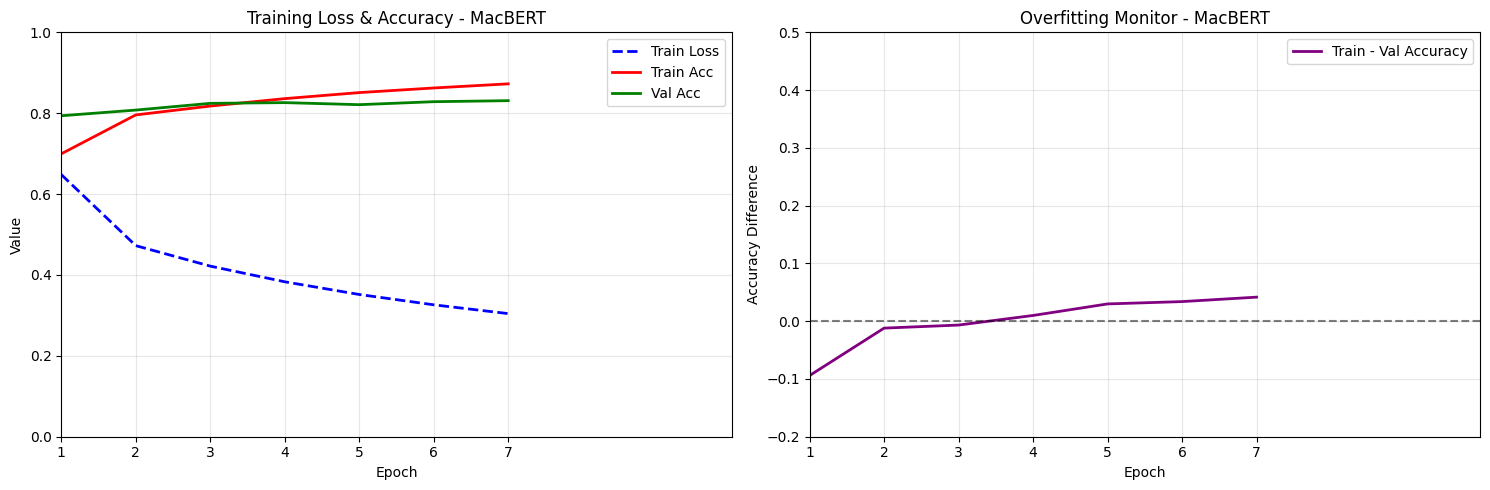


TRAINING SUMMARY
Model Name: MacBERT
Final Train Loss: 0.3045
Final Train Accuracy: 0.8726
Final Val Loss: 0.4421
Final Val Accuracy: 0.8310
Best Val Accuracy: 0.8310 (Epoch 7)
Final Overfitting Gap: 0.0416


In [8]:
# 绘制训练曲线
plot_training_curves("MacBERT", bert_history)

# 打印训练摘要
print_training_summary("MacBERT", bert_history)

Testing:   0%|          | 0/58486 [00:00<?, ?it/s]


BERT MODEL TEST RESULTS
Model Name: MacBERT
Test Accuracy: 0.8247
Test Precision (weighted): 0.8248
Test Recall (weighted): 0.8247
Test F1 Score (weighted): 0.8226

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8822    0.8232    0.8517     18608
     Neutral     0.7691    0.6819    0.7229     14723
    Positive     0.8149    0.9092    0.8595     25155

    accuracy                         0.8247     58486
   macro avg     0.8221    0.8048    0.8114     58486
weighted avg     0.8248    0.8247    0.8226     58486



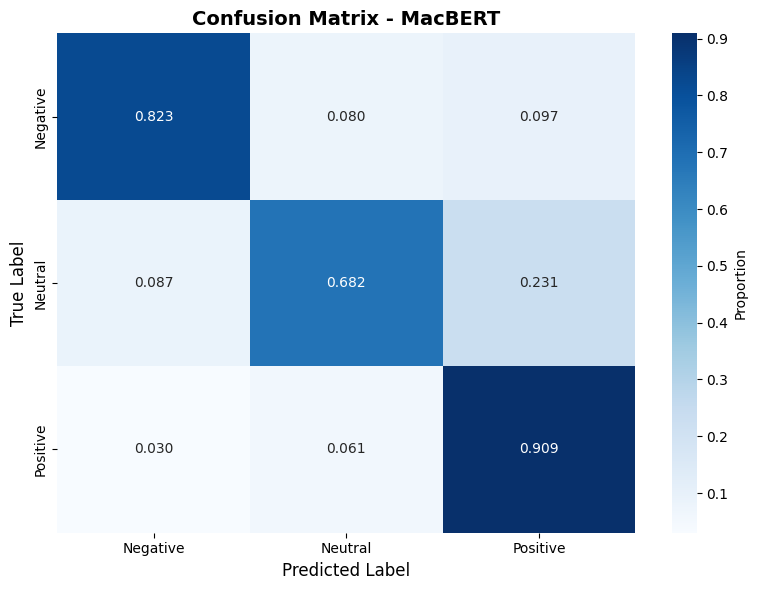


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8822, Recall=0.8232, F1=0.8517, Support=18608
 Neutral: Precision=0.7691, Recall=0.6819, F1=0.7229, Support=14723
Positive: Precision=0.8149, Recall=0.9092, F1=0.8595, Support=25155


In [9]:
# 进行全面测试
bert_test_results = test_bert_model_comprehensive(
    model=bert,
    model_name="MacBERT",
    test_loader=test_loader,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive'],
    use_amp=True
)


In [ ]:
save_training_results(
    model=bert, 
    model_name="MacBERT", 
    set_epochs=num_epochs,
    actual_epochs=len(bert_history['train_losses']), 
    device=device, 
    use_pretrained_embeddings=False, 
    training_history=bert_history, 
    test_results=bert_test_results, 
    save_path="results/model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: MacBERT (BERT)
  - 实际训练轮数: 7
  - 测试准确率: 0.8247
  - 测试F1分数: 0.8226
  - 记录时间: 2025-11-25 22:31:39
  - 总记录数: 6
